<a href="https://colab.research.google.com/github/pouvelenc/DD2365-aflum/blob/main/mesh_refinement_turb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DD2365 - Project**
## **Adaptive algorithm for NS with slip-with-friction BCs**
**Povel Kann**

## **Environment setup**

In [91]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

import logging

logging.getLogger('FFC').setLevel(logging.CRITICAL)
logging.getLogger('UFL').setLevel(logging.CRITICAL)
logging.getLogger('DOLFIN').setLevel(logging.CRITICAL)

### **Mesh**

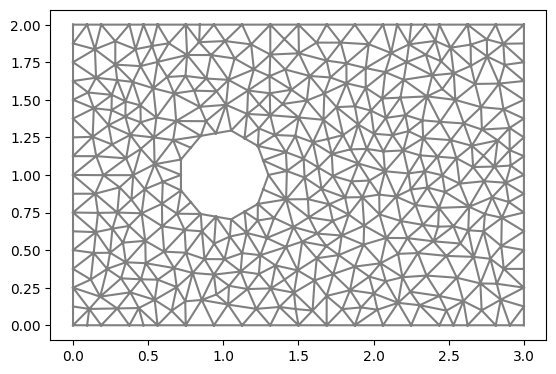

In [92]:
# Define rectangular domain
length = 3
height = 2

# Define circle
xc = 1
yc = 0.5*height
rc = 0.3

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], length)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], height)

class Skin_Friction(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and (not near(x[0], 0.0)) and (not near(x[0], length)) \
                and (not near(x[1], 0.0)) and (not near(x[1], height)))

left = Left()
right = Right()
lower = Lower()
upper = Upper()
skin_friction = Skin_Friction()

# Generate mesh
resolution = 16
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(length,height)) - Circle(Point(xc,yc),rc), resolution)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)
skin_friction.mark(boundaries, 5)

plt.figure()
plot(mesh)
plt.show()

## **Code**

#### **Mesh refinement**

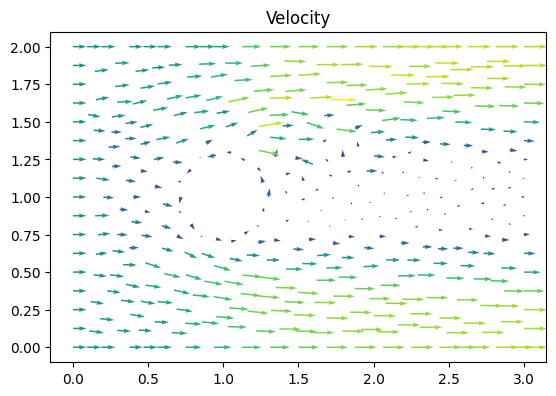

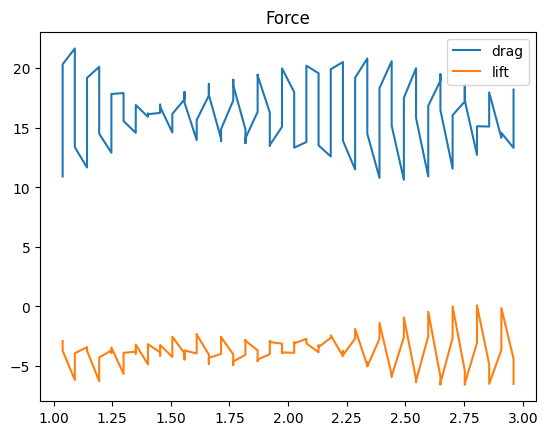

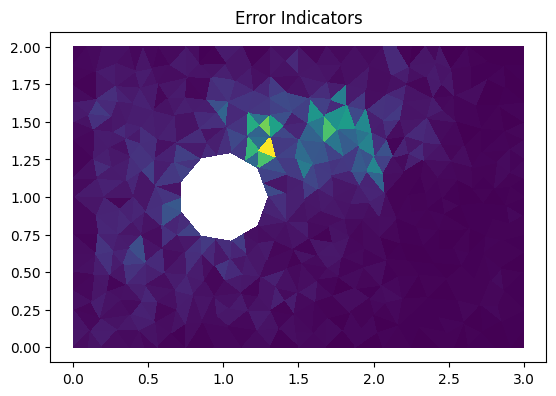

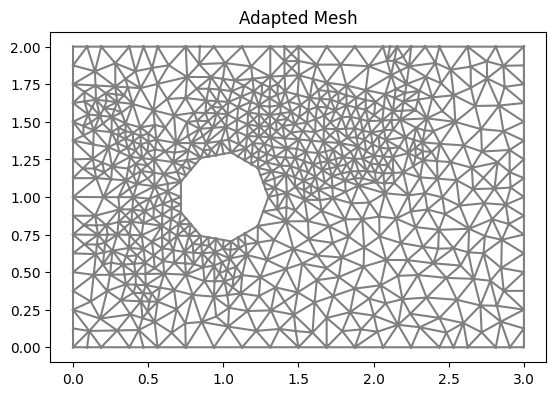

In [93]:
# Set viscosity
nu = 1.0e-5

# finite element spaces for velocity and pressure
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)


# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], height)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], length)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], length)) and (not near(x[1], 0.0)) and (not near(x[1], height))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

uin = 4.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
bcp1 = DirichletBC(Q, pout, dbc_right)

bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and linear solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()


# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 4.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = 2.0*h*u_mag

# slip-with-friction boundary conditions, implemented as penalty terms
e_n = FacetNormal(mesh)
e_t = as_vector([e_n[1], -e_n[0]])
C_alpha = 1.0e2
alpha = C_alpha/h
omega = 1.0
beta = 16

# angular (tangential) velocity
u_t = 2.0

# Smagorinsky model (simplified)
C_t = 1.0e-2

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx \
    - p1*div(v)*dx \
    + nu*inner(grad(um), grad(v))*dx \
    + C_t*h*h*sqrt(inner(grad(um1), grad(um1)))*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx \
    + d2*div(um)*div(v)*dx \
    + alpha*(inner(dot(um,e_n), dot(v,e_n)))*ds(5) \
    + beta*(inner(dot(um,e_t) - u_t, dot(v,e_t)))*ds(5)

au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)


# Define the direction of the force to be computed
phi_x_D = 1.0
phi_y_D = 0.0
phi_x_L = 0.0
phi_y_L = 1.0

psi_expression_D = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x_D, phi_y=phi_y_D, element = V.ufl_element())
psi_D = interpolate(psi_expression_D, V)

psi_expression_L = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x_L, phi_y=phi_y_L, element = V.ufl_element())
psi_L = interpolate(psi_expression_L, V)

Force_D = inner((u1 - u0)/dt + grad(um1)*um1, psi_D)*dx - p1*div(psi_D)*dx + nu*inner(grad(um1), grad(psi_D))*dx
Force_L = inner((u1 - u0)/dt + grad(um1)*um1, psi_L)*dx - p1*div(psi_L)*dx + nu*inner(grad(um1), grad(psi_L))*dx

# Force normalization
D = 2*rc
normalization = -2.0/D

# Force computation data
force_array_D = np.array(0.0)
force_array_D = np.delete(force_array_D, 0)
force_array_L = np.array(0.0)
force_array_L = np.delete(force_array_L, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

us = []
ps = []

# Time stepping
T = 3
t = dt
while t < T + DOLFIN_EPS:
    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F_D = assemble(Force_D)
        F_L = assemble(Force_L)
        if (t > start_sample_time):
          force_array_D = np.append(force_array_D, normalization*F_D)
          force_array_L = np.append(force_array_L, normalization*F_L)
          time = np.append(time, t)

        k += 1

    # Update time step
    us.append(Function(V))
    ps.append(Function(Q))
    us[-1].assign(u1)
    ps[-1].assign(p1)

    u0.assign(u1)
    t += dt


# Plot solution
plt.figure()
plot(u1, title="Velocity")
plt.show()

plt.figure()
plt.title("Force")
plt.plot(time, force_array_D, label="drag")
plt.plot(time, force_array_L, label="lift")
plt.legend()
plt.show()



# Dual function spaces
VEa = VectorElement("CG", mesh.ufl_cell(), 2)
QEa = FiniteElement("CG", mesh.ufl_cell(), 1)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)

# Dual trial/test functions
phi, theta = TrialFunctions(Wa)
psi, chi = TestFunctions(Wa)

# Dual solution functions
phi_theta = Function(Wa)

def dual_boundary_conditions(Wa, boundaries, psi_L):
    return [
        # φ = ψ_D on cylinder (boundary 5)
        DirichletBC(Wa.sub(0), psi_L, boundaries, 5),
        # φ = 0 on other boundaries
        DirichletBC(Wa.sub(0), Constant((0, 0)), boundaries, 1),  # left
        DirichletBC(Wa.sub(0), Constant((0, 0)), boundaries, 2),  # right
        DirichletBC(Wa.sub(0), Constant((0, 0)), boundaries, 3),  # lower
        DirichletBC(Wa.sub(0), Constant((0, 0)), boundaries, 4),  # upper
    ]

dual_bcs = dual_boundary_conditions(Wa, boundaries, psi_L)

# Reverse time and solve dual
dual_solutions = []
phi_theta_n = Function(Wa)  # Initial condition (zero)

for t_step in reversed(range(len(us))):
    u_primal, p_primal = us[t_step], ps[t_step]

    # Assemble dual equation
    a_dual = (
        inner(phi, psi)*dx
        + dt * (
            inner(dot(u_primal, grad(phi)), psi)*dx
            + nu*inner(grad(phi), grad(psi))*dx
            - inner(theta, div(psi))*dx
            + inner(div(phi), chi)*dx
            + inner(dot(grad(u_primal), phi), psi)*dx
        )
    )
    L_dual = inner(phi_theta_n.split()[0], psi)*dx

    solve(a_dual == L_dual, phi_theta, bcs=dual_bcs)
    dual_solutions.append((phi_theta.copy(deepcopy=True)).split())
    phi_theta_n.assign(phi_theta)


#phi_adjoint = phi_theta.split()[0]
#plt.figure()
#plot(phi_adjoint, title="Adjoint Velocity")
#plt.show()

# Error indicator calculation parameters
C_h = 1/8.0    # Spatial interpolation constant
C_k = 1/2.0    # Temporal interpolation constant
TOL = 0.05     # Target error tolerance
REFINE_FRACTION = 0.3  # Refine top 30% of cells

def compute_error_indicators(primal_sols, dual_sols, mesh, dt):
    """Calculate error indicators using residuals and dual derivatives"""
    # Create DG0 space for cell-wise quantities
    DG0 = FunctionSpace(mesh, "DG", 0)
    error_indicators = Function(DG0)
    error_indicators.vector()[:] = 0.0

    # Project cell diameter to DG0 space
    h = CellDiameter(mesh)
    h_project = project(h, DG0)
    h_array = h_project.vector().get_local()

    for t_step in range(len(primal_sols)):
        # Get solutions at current time step
        u, p = primal_sols[t_step]
        phi, theta = dual_sols[t_step]

        # Compute residuals ----------------------------------------------------
        # R1: Momentum residual (simplified)
        R1 = (u - us[-1])/dt + dot(grad(u), u) + grad(p) - nu*div(grad(u))
        R1_norm = project(sqrt(inner(R1, R1)), DG0)

        # R3: Divergence residual
        R3 = div(u)
        R3_norm = project(abs(R3), DG0)

        # Dual derivatives -----------------------------------------------------
        # Compute gradient magnitudes
        grad_phi = project(sqrt(inner(grad(phi), grad(phi))), DG0)
        grad_theta = project(sqrt(inner(grad(theta), grad(theta))), DG0)

        # Accumulate error indicators ------------------------------------------
        e_D = (R1_norm.vector().get_local() *
              (C_h * h_array**2 * grad_phi.vector().get_local()/h_array +  # D2 approx
               C_k * dt * np.linalg.norm(phi.vector().get_local())))

        e_M = (R3_norm.vector().get_local() *
              (C_h * h_array**2 * grad_theta.vector().get_local()/h_array +
               C_k * dt * np.linalg.norm(theta.vector().get_local())))

        error_indicators.vector()[:] += (e_D + e_M) * dt

    return error_indicators

def adapt_mesh(error_indicators, mesh):
    """Mark and refine cells based on error indicators"""
    # Convert error indicators to MeshFunction
    DG0 = FunctionSpace(mesh, "DG", 0)
    error_func = Function(DG0)
    error_func.vector()[:] = error_indicators.vector().get_local()

    # Mark cells using threshold
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
    error_values = error_func.vector().get_local()
    threshold = np.percentile(error_values, 80)

    for cell in cells(mesh):
        cell_markers[cell] = error_values[cell.index()] > threshold

    # Refine and return new mesh
    return refine(mesh, cell_markers)


primal_solutions = [(us[i], ps[i]) for i in range(len(us))]
error_indicators = compute_error_indicators(primal_solutions, dual_solutions, mesh, dt)
mesh = adapt_mesh(error_indicators, mesh)

plt.figure()
plot(error_indicators)
plt.title("Error Indicators")
plt.show()

plt.figure()
plot(mesh)
plt.title("Adapted Mesh")
plt.show()